# Model Explainability with SHAP

Model explainability refers to the ability to understand and interpret the inner workings of a machine learning model. It allows us to understand why a model makes certain predictions or decisions, and helps us to build trust in the model's outputs.

SHAP (SHapley Additive exPlanations) is a popular method for model explainability that uses the Shapley value, a concept from cooperative game theory, to assign feature importance to each input feature in a model. The Shapley value measures the marginal contribution of a feature to a prediction by comparing the predictions of all possible subsets of features with and without that feature.

To compute SHAP values, the method uses a weighted combination of feature values for each instance in the dataset. The weights are calculated based on the contribution of each feature to the model's output for that instance. The SHAP values represent the difference between the expected output of the model and the output when a particular feature is masked, indicating the impact of each feature on the model's predictions.

The SHAP values can be visualized in a variety of ways, such as bar charts, scatter plots, or summary plots. These visualizations allow us to easily interpret the impact of each feature on the model's predictions, and can help us identify which features are most important for a particular prediction.

In [10]:
from deepmol.feature_selection import LowVarianceFS
from deepmol.splitters import SingletaskStratifiedSplitter
from deepmol.compound_featurization import MACCSkeysFingerprint
from deepmol.loaders import CSVLoader

# Load the data and create MACCS keys features, do feature selection and split into train and test sets
loader = CSVLoader(dataset_path='../data/CHEMBL217_reduced.csv',
                   smiles_field='SMILES',
                   id_field='Original_Entry_ID',
                   labels_fields=['Activity_Flag'],
                   mode='auto',
                   shard_size=2500)
# create the dataset
data = loader.create_dataset(sep=',', header=0)
MACCSkeysFingerprint().featurize(data)
LowVarianceFS(0.15).select_features(data)
print(data.get_shape())
train_df, test_df = SingletaskStratifiedSplitter().train_test_split(data, frac_train=0.8, seed=123)

2023-03-17 16:36:41,593 — ERROR — Molecule with smiles: ClC1=C(N2CCN(O)(CC2)=C/C=C/CNC(=O)C=3C=CC(=CC3)C4=NC=CC=C4)C=CC=C1Cl removed from dataset.
2023-03-17 16:36:41,594 — INFO — Assuming classification since there are less than 10 unique y values. If otherwise, explicitly set the mode to 'regression'!


[16:36:41] Explicit valence for atom # 6 N, 5, is greater than permitted


2023-03-17 16:36:42,515 — INFO — Mols_shape: (2499,)
2023-03-17 16:36:42,516 — INFO — Features_shape: (2499, 76)
2023-03-17 16:36:42,516 — INFO — Labels_shape: (2499,)
((2499,), (2499, 76), (2499,))


In [11]:
from deepmol.models import SklearnModel
from sklearn.ensemble import RandomForestClassifier

# Build and train a simple RandomForest model
rf = RandomForestClassifier(n_jobs=-1, random_state=123)
model = SklearnModel(model=rf)
model.fit(train_df)

RandomForestClassifier(n_jobs=-1, random_state=123)

X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but Ran

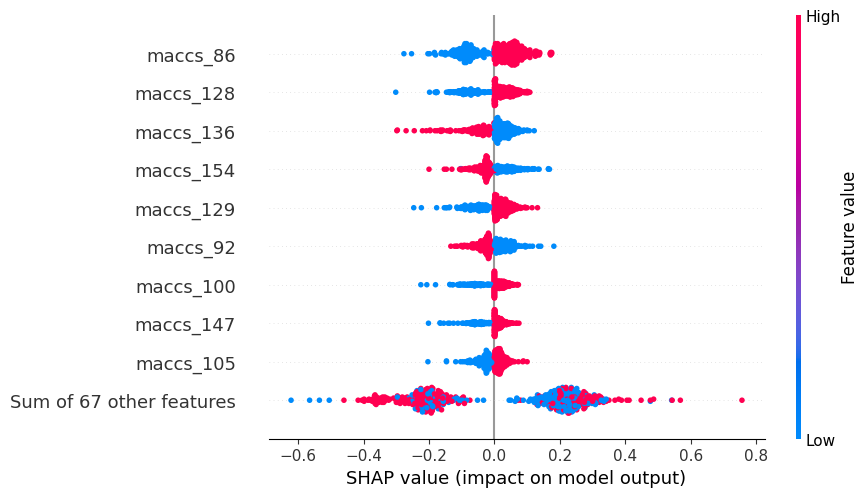

In [12]:
from deepmol.feature_importance import ShapValues

# compute shap values
shap_calc = ShapValues(test_df, model)
shap_calc.computePermutationShap()

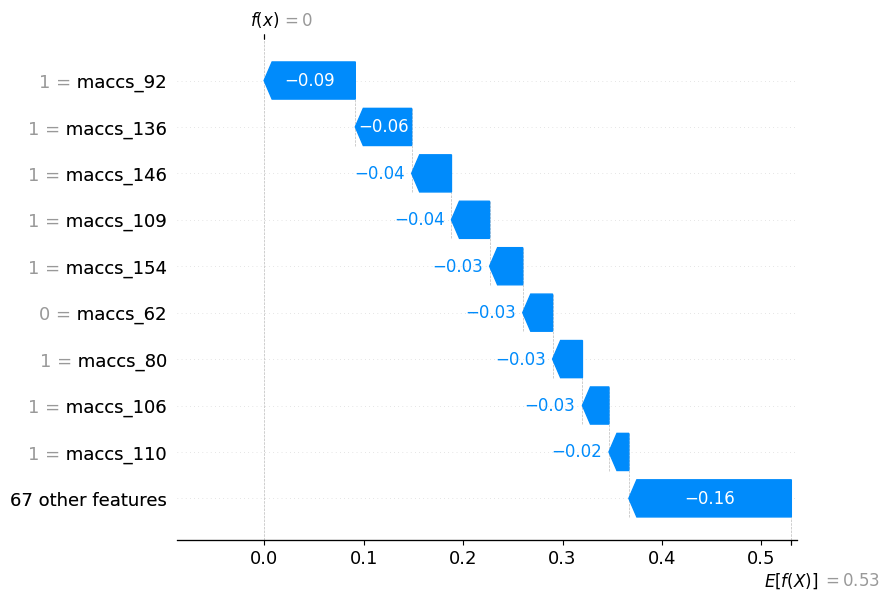

In [13]:
# check impact of features on specific molecules
shap_calc.plotSampleExplanation(index=0, plot_type='waterfall')

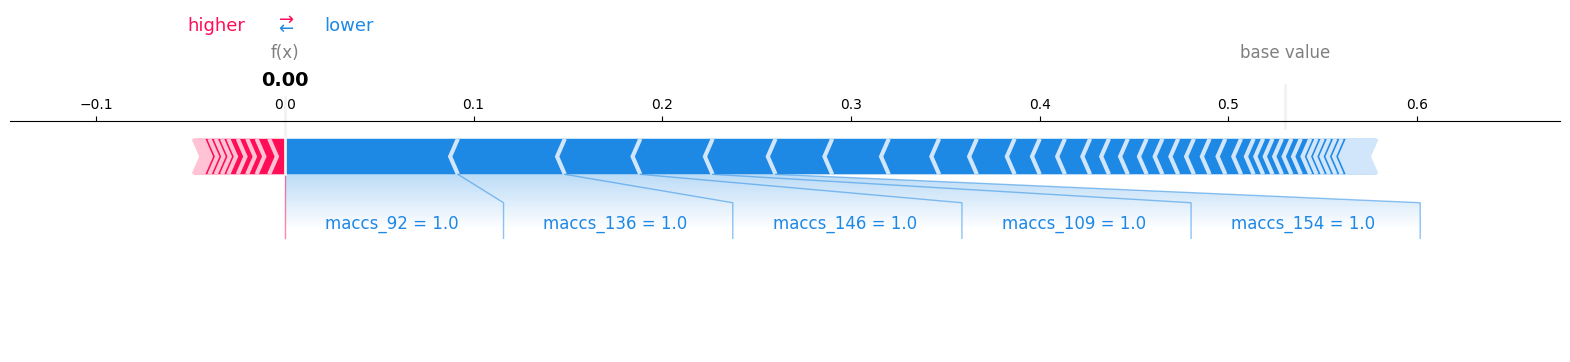

In [14]:
# just another way to plot the same thing
shap_calc.plotSampleExplanation(index=0, plot_type='force', matplotlib=True)

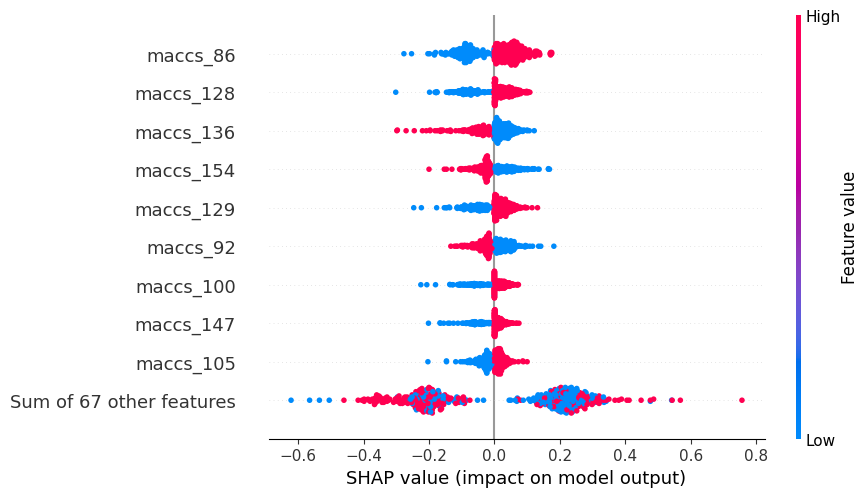

In [15]:
# if no index is passed, it plots for all features
shap_calc.plotFeatureExplanation()

['maccs_38', 'maccs_42', 'maccs_57', 'maccs_59', 'maccs_62', 'maccs_64', 'maccs_65', 'maccs_75', 'maccs_77', 'maccs_79', 'maccs_80', 'maccs_81', 'maccs_82', 'maccs_83', 'maccs_85', 'maccs_86', 'maccs_87', 'maccs_88', 'maccs_90', 'maccs_91', 'maccs_92', 'maccs_93', 'maccs_94', 'maccs_95', 'maccs_96', 'maccs_97', 'maccs_98', 'maccs_100', 'maccs_101', 'maccs_102', 'maccs_103', 'maccs_104', 'maccs_105', 'maccs_106', 'maccs_107', 'maccs_108', 'maccs_109', 'maccs_110', 'maccs_111', 'maccs_112', 'maccs_113', 'maccs_114', 'maccs_115', 'maccs_116', 'maccs_117', 'maccs_118', 'maccs_120', 'maccs_122', 'maccs_124', 'maccs_126', 'maccs_127', 'maccs_128', 'maccs_129', 'maccs_130', 'maccs_131', 'maccs_132', 'maccs_133', 'maccs_134', 'maccs_135', 'maccs_136', 'maccs_138', 'maccs_139', 'maccs_140', 'maccs_143', 'maccs_144', 'maccs_146', 'maccs_147', 'maccs_149', 'maccs_150', 'maccs_151', 'maccs_152', 'maccs_154', 'maccs_155', 'maccs_157', 'maccs_159', 'maccs_160']


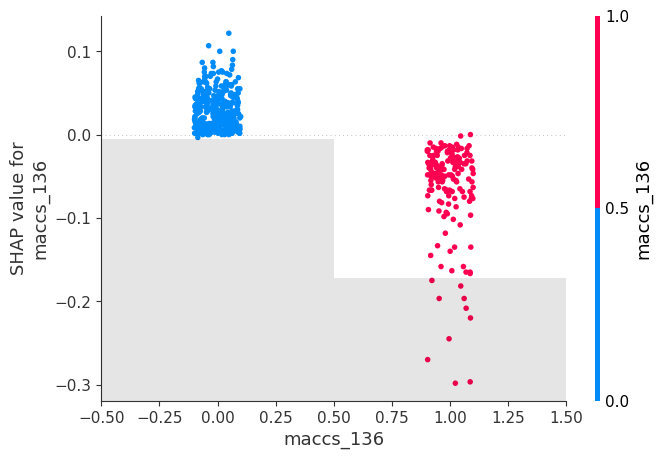

In [73]:
# plot for a specific feature (impact of the feature across the entire dataset)
print(data.feature_names)
shap_calc.plotFeatureExplanation(index=59)

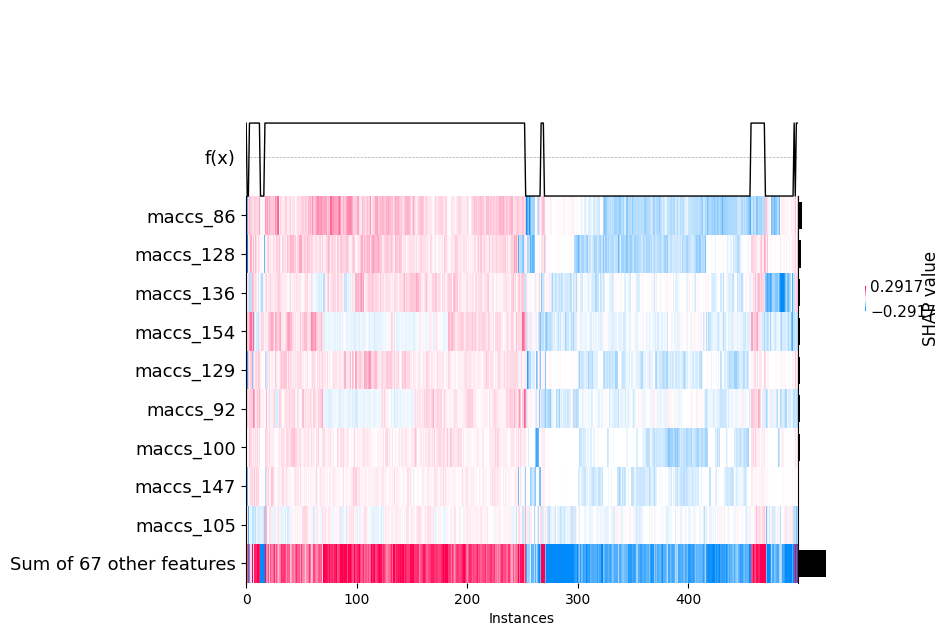

In [17]:
# heat map of molecules vs features
shap_calc.plotHeatMap()

### Draw relevant features

It is possible to plot the ON bits (or some of them) in a molecule for MACCS Keys, Morgan and RDK Fingeprints. IT is also possible to draw those bits on the respective molecule. This can be allied with the Shap Values calculation to highlight the zone of the molecule that most contributed to a certain prediction, for instance, the substructure in the molecule that most contributed to its classification as an active or inactive molecule against a receptor.

Prediction:  [0.93 0.07]
Actual Value:  0


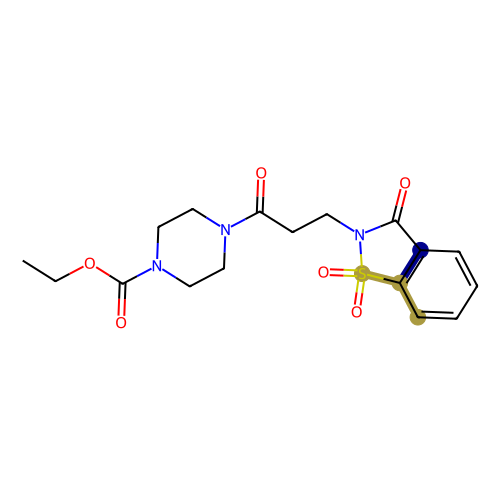

In [76]:
from deepmol.utils.utils import draw_MACCS_Pattern

# draw the relevant bits for a specific molecule
# lets check for the feature 59 (feature maccs_136) and the molecule 0
patt_number = 59
mol_number = 0

prediction = model.predict(test_df)[mol_number]
actual_value = test_df.y[mol_number]
print('Prediction: ', prediction)
print('Actual Value: ', actual_value)
smi = test_df.mols[mol_number]

draw_MACCS_Pattern(smi, patt_number)